- Most/least responsive cells
- Most/least impactrul (damaging) drugs

- Most/least predictive cells (lowest error)
- Most/least predictive drugs (lowest error)

------------

- Encode count of cells/drugs
- Separate results by study

------------

- https://seaborn.pydata.org/tutorial/categorical.html#categorical-tutorial
- https://seaborn.pydata.org/tutorial/distributions.html#distribution-tutorial

In [1]:
!which python

/vol/ml/apartin/anaconda3/envs/p1/bin/python


In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import os
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import collections
from glob import glob

import sklearn
import numpy as np
import pandas as pd
from math import sqrt

In [3]:
runs_dir_name = 'out_lgbm'
file_path = Path.cwd()
print(file_path)

/vol/ml/apartin/projects/DrugResponseViz/notebooks


In [4]:
runs_dir_path = Path(file_path / '..' / runs_dir_name)
runs_dirs = [Path(p) for p in glob(str(runs_dir_path/'run_*'))]
# pred = pd.read_csv(os.path.join(predsdir, 'dev_lgb_reg_preds.csv'))

In [5]:
# Load cell metadata
cancer_types = pd.read_csv(file_path/'../data/combined_cancer_types', sep='\t', names=['CELL', 'CTYPE'])
print(cancer_types.shape)
display(cancer_types[:2])

# cmeta = pd.read_csv(file_path/'../data/combined_metadata_2018May.txt', sep='\t')
# print(cmeta.shape)

# dmeta = pd.read_csv(file_path/'../data/drug_info', sep='\t')
# print(dmeta.shape)

(14590, 2)


,CELL,CTYPE
0,CCLE.ALLSIL,Acute_Lymphoblastic_Leukemia
1,CCLE.DND41,Acute_Lymphoblastic_Leukemia


In [6]:
mltype = 'reg'

# Pre-proc data to analyze ML predictions

Combine predictions from all runs (shuffles/splits)

In [7]:
# def add_run_col(prd_df, dir_name):
#     prd_df['run'] = str(dir_name).split(os.sep)[-1].split('_')[-1]
#     return prd_df

def reorg_cols(df):
    cols = df.columns.tolist()
    cols.remove('run')
    return df[['run'] + cols]
    
def agg_preds_from_runs(runs_dirs):
    """ Aggregate predictions bootstraped ML trainings. """
    prd_te = []
    for i, dir_name in enumerate(runs_dirs):
        # prd_tr_ = pd.read_csv(dir_name/'preds_tr.csv')
        # prd_vl_ = pd.read_csv(dir_name/'preds_vl.csv')
        prd_te_ = pd.read_csv(dir_name/'preds_te.csv')
        
        prd_te_['err'] = abs(prd_te_['y_true'] - prd_te_['y_pred']) # add col 'err'
        # prd_te_ = add_run_col(prd_df=prd_te_, dir_name=d)  # add col 'run' identifier
        prd_te_['run'] = str(dir_name).split(os.sep)[-1].split('_')[-1]  # add col 'run' identifier
        prd_te.append(prd_te_)  # append run

        if i%20==0:
            print(f'Processing {dir_name}')
            
    # aggregate to df
    prd_te = pd.concat(prd_te, axis=0)
    return prd_te

In [8]:
# Concat preds from all runs      
prd_te = agg_preds_from_runs(runs_dirs)
prd_te = reorg_cols(prd_te)
prd_te = prd_te.reset_index().rename(columns={'index': 'idx'})
prd_te.insert(loc=2, column='source', value=[s.split('.')[0].lower() for s in prd_te['CELL']]) # add 'source' column

Processing /vol/ml/apartin/projects/DrugResponseViz/notebooks/../out_lgbm/run_s000
Processing /vol/ml/apartin/projects/DrugResponseViz/notebooks/../out_lgbm/run_s020
Processing /vol/ml/apartin/projects/DrugResponseViz/notebooks/../out_lgbm/run_s040
Processing /vol/ml/apartin/projects/DrugResponseViz/notebooks/../out_lgbm/run_s060
Processing /vol/ml/apartin/projects/DrugResponseViz/notebooks/../out_lgbm/run_s080


In [9]:
prd_te[:2]

,idx,run,source,CELL,DRUG,AUC,y_true,y_pred,err
0,0,s000,ctrp,CTRP.Hs-729,CTRP.116,0.8039,0.8039,0.837310,0.033410
1,1,s000,ctrp,CTRP.NCI-H1184,CTRP.177,0.8107,0.8107,0.837507,0.026807


In [10]:
# Add meta
print(prd_te.shape)
prd_te = pd.merge(prd_te, cancer_types, how='left', on='CELL')
print(prd_te.shape)

(5299400, 9)
(5299400, 10)


# Pre-proc data to analyze raw response (w/o preds)
Get all responses from Top21.

Instead of Top21, we can use the entire response dataframe(?)

In [11]:
dir_name = runs_dirs[0]
prd_tr_ = pd.read_csv(dir_name/'preds_tr.csv')
prd_vl_ = pd.read_csv(dir_name/'preds_vl.csv')
prd_te_ = pd.read_csv(dir_name/'preds_te.csv')
rsp = pd.concat([prd_tr_, prd_vl_, prd_te_], axis=0)
rsp = rsp.reset_index().rename(columns={'index': 'idx'})
rsp.insert(loc=1, column='source', value=[s.split('.')[0].lower() for s in rsp['CELL']]) # add 'source' column

display(rsp[:2])

,idx,source,CELL,DRUG,AUC,y_true,y_pred
0,0,ctrp,CTRP.JHOC-5,CTRP.391,0.8934,0.8934,0.824278
1,1,gdsc,GDSC.CAKI-1,GDSC.157,0.6228,0.6228,0.717275


In [12]:
# Add meta
print(rsp.shape)
rsp = pd.merge(rsp, cancer_types, how='left', on='CELL')
print(rsp.shape)

(529940, 7)
(529940, 8)


# Cell Responsiveness

Are the cell names consistent across sources?

In [13]:
def agg_rsp_by_dim(df, dim):
    """ Aggregate response by 'dim' where dim is either 'CELL' or 'DRUG'. """
    df_ = df.copy()
    
    mean_col = 'auc_mean'
    std_col  = 'auc_std'
    df_[mean_col] = df_['AUC']
    df_[std_col]  = df_['AUC']
    # rsp_[f'{col.lower()}_mean'] = rsp_[col]
    # rsp_[f'{col.lower()}_std'] = rsp_[col]
        
    # df_ = df_.groupby([dim]).agg({mean_col: np.mean, std_col: np.std, 'idx': len})
    if dim=='CELL':
        df_ = df_.groupby([dim]).agg({mean_col: np.mean, std_col: np.std, 'idx': len, 'CTYPE': np.unique})
    else:
        df_ = df_.groupby([dim]).agg({mean_col: np.mean, std_col: np.std, 'idx': len})
    df_ = df_.rename(columns={'idx': 'cnt'})
    df_ = df_.reset_index()
    return df_    

In [14]:
rsp_cell = agg_rsp_by_dim(rsp, dim='CELL')
rsp_cell[:2]

,CELL,auc_mean,auc_std,cnt,CTYPE
0,CCLE.22RV1,0.769696,0.162658,24,Prostate_Adenocarcinoma
1,CCLE.42MGBA,0.738280,0.172672,20,Glioblastoma_Multiforme


In [15]:
# Get the N most responsive cells
N = 10

# Most responsive cells
most_rsp_cells = rsp_cell.sort_values('auc_mean', ascending=True)[:N]
display(most_rsp_cells[:2])

# Least responsive cells
least_rsp_cells = rsp_cell.sort_values('auc_mean', ascending=True)[-N:]
display(least_rsp_cells[:2])

,CELL,auc_mean,auc_std,cnt,CTYPE
427,CTRP.HCC-33,0.472225,0.219620,4,Lung_Small_Cell_Carcinoma
729,CTRP.SCLC-21H,0.482993,0.192537,15,Lung_Small_Cell_Carcinoma


,CELL,auc_mean,auc_std,cnt,CTYPE
529,CTRP.KPL-1,0.928594,0.075331,397,Breast_Invasive_Carcinoma
641,CTRP.NCI-H2172,0.928872,0.081286,383,Lung_Non-Small_Cell_Carcinoma


In [16]:
# Agg most and least responsive cells
c_names = most_rsp_cells['CELL'].tolist()
c_names.extend( least_rsp_cells['CELL'].tolist() )

tmp_rsp = rsp[ rsp['CELL'].isin(c_names) ].copy()
print(tmp_rsp['CELL'].unique())
print(tmp_rsp.shape)

['CTRP.RCC10RGB' 'CTRP.BEN' 'CTRP.REC-1' 'CTRP.SK-MEL-28' 'CTRP.KPL-1'
 'CTRP.NCI-H2172' 'CTRP.KARPAS-620' 'CTRP.CL-34' 'CTRP.HT-29'
 'GDSC.SW1116' 'CTRP.RERF-LC-Ad1' 'gCSI.NCI-H292' 'gCSI.KMM-1'
 'gCSI.IGROV-1' 'gCSI.TC-71' 'CTRP.RD-ES' 'CTRP.BCP-1' 'gCSI.KMS-26'
 'CTRP.SCLC-21H' 'CTRP.HCC-33']
(4005, 8)


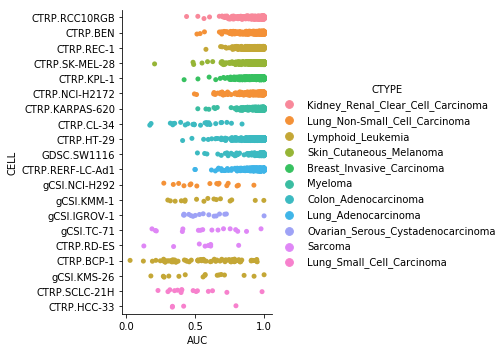

In [19]:
# g = sns.catplot(data=tmp_rsp, x='CELL', y='AUC', kind='strip', hue='CTYPE');
# g.set_xticklabels(rotation=70);

g = sns.catplot(data=tmp_rsp, y='CELL', x='AUC', kind='strip', hue='CTYPE');
# g = sns.catplot(data=tmp_rsp, y='CELL', x='AUC', kind='strip', hue='source');

### Demo viz

In [20]:
# c_names = rsp['CELL'].sample(n=4).values  # get names of random cells
# tmp_rsp = rsp[ rsp['CELL'].isin(c_names) ].copy()
# print(tmp_rsp['CELL'].unique())
# print(tmp_rsp.shape)

In [21]:
# g = sns.catplot(data=tmp_rsp, x='CELL', y='AUC', kind='strip');
# g = sns.catplot(data=tmp_rsp, x='CELL', y='AUC', kind='box');

# g = sns.catplot(data=tmp_rsp, x='CELL', y='AUC', kind='strip', hue='CTYPE');
# g.set_xticklabels(rotation=70);

# Drug Impactfulness

In [22]:
rsp_drug = agg_rsp_by_dim(rsp, dim='DRUG')
rsp_drug = rsp_drug.reset_index()

In [23]:
# Get the N most responsive cells
N = 10

# Most responsive cells
most_rsp_drugs = rsp_drug.sort_values('auc_mean', ascending=True)[:N]
display(most_rsp_drugs[:2])

# Least responsive cells
least_rsp_drugs = rsp_drug.sort_values('auc_mean', ascending=True)[-N:]
display(least_rsp_drugs[:2])

,index,DRUG,auc_mean,auc_std,cnt
1139,1139,NSC.747973,0.208999,0.145005,162
553,553,GDSC.104,0.326878,0.202973,185


,index,DRUG,auc_mean,auc_std,cnt
1761,1761,NSC.98332,0.990776,0.011697,55
911,911,NSC.622218,0.991168,0.013014,44


In [24]:
# Agg most and least responsive cells
d_names = most_rsp_drugs['DRUG'].tolist()
d_names.extend( least_rsp_drugs['DRUG'].tolist() )

tmp_rsp = rsp[ rsp['DRUG'].isin(d_names) ].copy()
print(tmp_rsp['DRUG'].unique())
print(tmp_rsp.shape)

['GDSC.268' 'NSC.747973' 'CTRP.542' 'CCLE.18' 'CTRP.309' 'CTRP.446'
 'GDSC.104' 'GDSC.201' 'CTRP.157' 'NSC.622218' 'NSC.754143' 'NSC.617192'
 'NSC.619130' 'NSC.615801' 'NSC.98332' 'NSC.665714' 'NSC.620620'
 'NSC.624360' 'NSC.750679' 'NSC.624780']
(4039, 8)


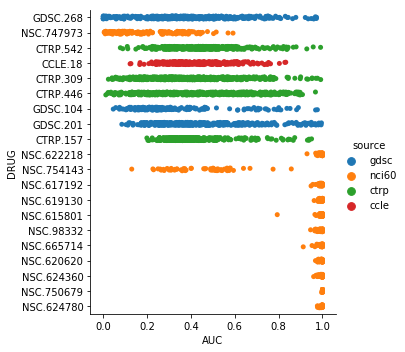

In [25]:
g = sns.catplot(data=tmp_rsp, y='DRUG', x='AUC', kind='strip', hue='source');

# Cell Predictiveness

In [29]:
def agg_prd_by_dim(df, dim):
    df_ = df.copy()
    
    mean_col = 'err_mean'
    std_col  = 'err_std'
    df_[mean_col] = df_['err']
    df_[std_col]  = df_['err']
    # rsp_[f'{col.lower()}_mean'] = rsp_[col]
    # rsp_[f'{col.lower()}_std'] = rsp_[col]
        
    # df_ = df_.groupby([dim]).agg({mean_col: np.mean, std_col: np.std, 'idx': len})
    if dim=='CELL':
        df_ = df_.groupby([dim]).agg({mean_col: np.mean, std_col: np.std, 'idx': len, 'CTYPE': np.unique})
    else:
        df_ = df_.groupby([dim]).agg({mean_col: np.mean, std_col: np.std, 'idx': len})
    df_ = df_.rename(columns={'idx': 'cnt'})
    df_ = df_.reset_index()        
    return df_  

In [30]:
prd_cell = agg_prd_by_dim(prd_te, dim='CELL')
prd_cell[:2]

,CELL,err_mean,err_std,cnt,CTYPE
0,CCLE.22RV1,0.066999,0.060342,234,Prostate_Adenocarcinoma
1,CCLE.42MGBA,0.088237,0.083734,210,Glioblastoma_Multiforme


In [32]:
# Get the N most responsive cells
N = 10

# Most responsive cells
most_prd_cells = prd_cell.sort_values('err_mean', ascending=True)[:N]
display(most_prd_cells[:2])

# Least responsive cells
least_prd_cells = prd_cell.sort_values('err_mean', ascending=True)[-N:]
display(least_prd_cells[:2])

,CELL,err_mean,err_std,cnt,CTYPE
785,CTRP.SW1088,0.034815,0.030465,4218,Glioblastoma_Multiforme
416,CTRP.GOS-3,0.035706,0.033799,4194,Brain_NOS


,CELL,err_mean,err_std,cnt,CTYPE
1523,gCSI.NCI-H292,0.150595,0.105609,160,Lung_Non-Small_Cell_Carcinoma
1463,gCSI.KMM-1,0.153332,0.119862,138,Lymphoid_Leukemia


In [27]:
prd_cell.sort_values('err_mean', ascending=True)[:4]

,CELL,err_mean,err_std,cnt
785,CTRP.SW1088,0.034815,0.030465,4218
416,CTRP.GOS-3,0.035706,0.033799,4194
473,CTRP.Hs-729,0.036052,0.033511,4175
825,CTRP.WM1799,0.036888,0.033020,4154


# Drug Predictiveness

In [28]:
prd_drug = agg_prd_by_dim(prd_te, dim='DRUG')
prd_drug[:3]

,DRUG,err_mean,err_std,cnt
0,CCLE.1,0.057175,0.042345,3055
1,CCLE.10,0.063626,0.052287,3174
2,CCLE.11,0.045181,0.034647,3010


In [29]:
prd_drug.sort_values('err_mean', ascending=True)[:4]

,DRUG,err_mean,err_std,cnt
812,NSC.25154,0.017677,0.027527,18926
1081,NSC.717477,0.018077,0.012793,602
840,NSC.32065,0.018967,0.040742,13956
892,NSC.59791,0.019139,0.015773,620
